In [18]:
import itertools
from collections import Counter
import datetime
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize



In [19]:
with open ('city_search.json','rt') as inf:
    sessions = json.load(inf)
sessions = pd.DataFrame(sessions)
sessions.head(5)


,cities,session_id,unix_timestamp,user
0,"[New York NY, Newark NJ]",[X061RFWB06K9V],[1442503708],"[[{'user_id': 2024, 'joining_date': '2015-03-2..."
1,"[New York NY, Jersey City NJ, Philadelphia PA]",[5AZ2X2A9BHH5U],[1441353991],"[[{'user_id': 2853, 'joining_date': '2015-03-2..."
2,[San Antonio TX],[SHTB4IYAX4PX6],[1440843490],"[[{'user_id': 10958, 'joining_date': '2015-03-..."
3,[Edmonton AB],[JBRB8MZGTX3M4],[1427268063],"[[{'user_id': 7693, 'joining_date': '2015-03-1..."
4,"[Phoenix AZ, Houston TX]",[YJCMPURC2FL9C],[1430559067],"[[{'user_id': 7506, 'joining_date': '2015-02-2..."


In [20]:
def clean_json(d):
    
    assert len(d['cities']) == 1
    d['cities'] = d['cities'][0]
    
    assert len(d['session_id']) == 1
    d['session_id'] = d['session_id'][0]
    
    assert len(d['unix_timestamp']) == 1
    d['timestamp'] = datetime.datetime.utcfromtimestamp(d['unix_timestamp'][0])
    del d['unix_timestamp']
    
    user_dict = d['user']
    
    assert len(user_dict) == 1
    user_dict = user_dict[0]
    
    assert len(user_dict) == 1
    user_dict = user_dict[0]
    
    d['user_id'] = user_dict['user_id']
    d['user_country'] = user_dict['country']
    
    del d['user']
    

    return d

    
    
    

In [21]:
with open ('city_search.json','rt') as inf:
    sessions = json.load(inf)
    
for d in sessions:
    clean_json(d)

sessions = pd.DataFrame(sessions)
sessions = sessions.set_index('session_id')

sessions.head(10)

,cities,timestamp,user_country,user_id
session_id,,,,
X061RFWB06K9V,"New York NY, Newark NJ",2015-09-17 15:28:28,UK,2024
5AZ2X2A9BHH5U,"New York NY, Jersey City NJ, Philadelphia PA",2015-09-04 08:06:31,DE,2853
SHTB4IYAX4PX6,San Antonio TX,2015-08-29 10:18:10,UK,10958
JBRB8MZGTX3M4,Edmonton AB,2015-03-25 07:21:03,IT,7693
YJCMPURC2FL9C,"Phoenix AZ, Houston TX",2015-05-02 09:31:07,UK,7506
LKOKP80QD6BEO,San Diego CA,2015-06-13 12:53:11,ES,3743
YOVUIM79SGS5Y,"Montreal QC, Chicago IL",2015-09-25 09:04:47,,8831
SHXEY67QWKP9K,"Calgary AB, New York NY",2015-05-16 08:48:24,,587
9P74JL5KMC9G9,"Chicago IL, New York NY",2015-06-20 16:04:06,US,365


In [22]:
sessions.user_country.replace('','Missing',inplace = True)
sessions.head(10)

,cities,timestamp,user_country,user_id
session_id,,,,
X061RFWB06K9V,"New York NY, Newark NJ",2015-09-17 15:28:28,UK,2024
5AZ2X2A9BHH5U,"New York NY, Jersey City NJ, Philadelphia PA",2015-09-04 08:06:31,DE,2853
SHTB4IYAX4PX6,San Antonio TX,2015-08-29 10:18:10,UK,10958
JBRB8MZGTX3M4,Edmonton AB,2015-03-25 07:21:03,IT,7693
YJCMPURC2FL9C,"Phoenix AZ, Houston TX",2015-05-02 09:31:07,UK,7506
LKOKP80QD6BEO,San Diego CA,2015-06-13 12:53:11,ES,3743
YOVUIM79SGS5Y,"Montreal QC, Chicago IL",2015-09-25 09:04:47,Missing,8831
SHXEY67QWKP9K,"Calgary AB, New York NY",2015-05-16 08:48:24,Missing,587
9P74JL5KMC9G9,"Chicago IL, New York NY",2015-06-20 16:04:06,US,365


In [23]:
sessions.user_country.value_counts()

US         3876
DE         3638
UK         3555
Missing    2820
FR         2298
ES         1953
IT         1882
Name: user_country, dtype: int64

# Answer question 1¶
There was a bug in the code and one country didn't get logged. It just shows up as an empty ﬁeld (""). Can you guess which country was that? How?

my basic idea to solve this problem is checking the 'searching time' habit of each country. the time difference can give us some hint about the geographic location of each country.

In [24]:
#hour_by_country = sessions.groupby('user_country').apply(lambda x:x.timestamp.dt.hour.value_counts(normalize = True))
hour_by_country = sessions.groupby('user_country').apply(lambda x:x.timestamp.dt.hour.value_counts(normalize = True)).unstack(fill_value = 0)
hour_by_country


,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
user_country,,,,,,,,,,,,,,,,,,,,,
DE,0.000000,0.000000,0.000825,0.002749,0.007971,0.020341,0.041781,0.075591,0.107752,0.107752,...,0.090159,0.075591,0.046729,0.019791,0.009346,0.003573,0.001100,0.000000,0.000000,0.000000
ES,0.000000,0.000000,0.000000,0.002560,0.010241,0.023041,0.047107,0.082437,0.100358,0.111111,...,0.086022,0.068612,0.038914,0.020993,0.006656,0.002560,0.000000,0.000512,0.000000,0.000000
FR,0.000000,0.000000,0.000435,0.000435,0.005222,0.024369,0.050479,0.071802,0.092689,0.102698,...,0.094865,0.079199,0.045692,0.019147,0.007398,0.003916,0.001305,0.000000,0.000000,0.000000
IT,0.000000,0.000000,0.001594,0.002657,0.012221,0.019129,0.049416,0.074920,0.093518,0.108395,...,0.088735,0.078108,0.050478,0.021785,0.012221,0.002657,0.000000,0.000000,0.000000,0.000000
Missing,0.011348,0.031206,0.058865,0.090780,0.097872,0.104255,0.103546,0.095035,0.100355,0.100000,...,0.004610,0.001418,0.000355,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
UK,0.000000,0.000000,0.000000,0.001688,0.005345,0.009283,0.020534,0.046414,0.076231,0.091139,...,0.103797,0.102954,0.067792,0.050070,0.020253,0.005626,0.001688,0.000281,0.000281,0.000000
US,0.046440,0.027348,0.010578,0.002838,0.000774,0.000516,0.000258,0.000000,0.000000,0.000258,...,0.047472,0.071723,0.091589,0.109907,0.097265,0.106811,0.092105,0.093395,0.090557,0.066305


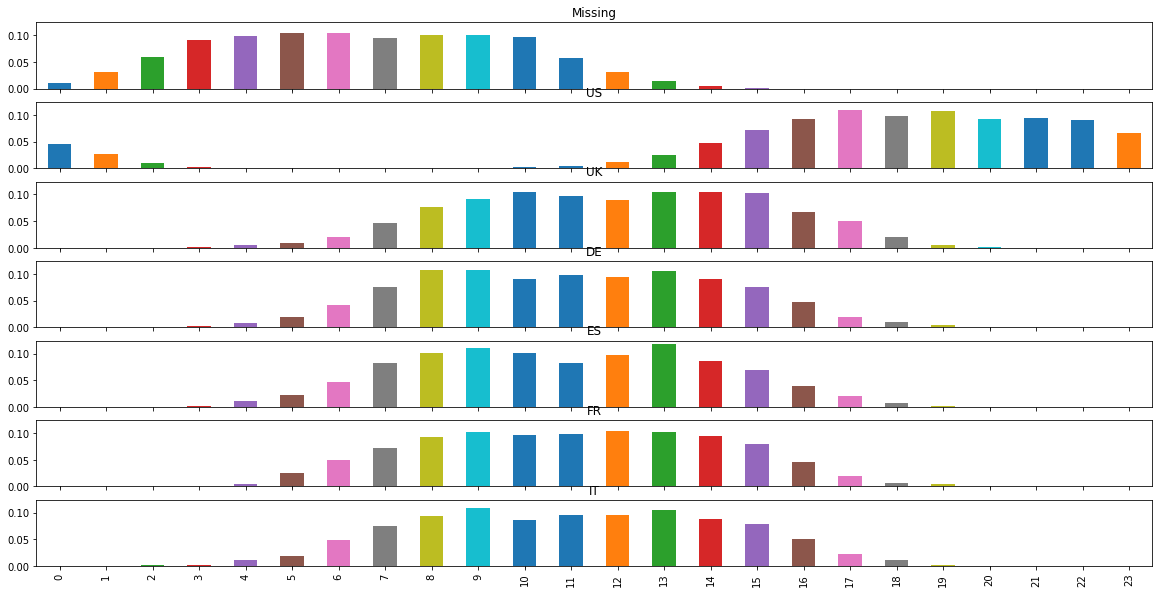

In [25]:
# plot the bar plot about search time ~ ratio
countries = ['Missing','US','UK','DE', 'ES', 'FR', 'IT']
fig,axes = plt.subplots(len(countries),1,sharex=True, sharey=True)
fig.set_size_inches(20,10)
for ax,country in itertools.zip_longest(axes,countries):
    hour_by_country.loc[country,:].plot(kind='bar',ax=ax)
    ax.set_title(country)
plt.show()


from above plot, we can see that, "the searching time" habit of the "Missing" and US are very different from 'UK','DE', 'ES', 'FR', 'IT'. so 'Missing' country, like US, cannot be in Europe .

also from the plot above, the Missing country has a time difference about 11~12 hours with US .

based on above two facts, I guess the Missing country is in Asia, and it must have good economic to allow people to travel aboard. Hence, I guess the Missing country may be China, Japan or South Korean.

# Answer question 2
For each city, ﬁnd the most likely city to be also searched for within the same session.

my basic idea to solve this problem is:

model each city as a vector. i-th value in the vector represents #search by i-th user
then calculate cosine similarity between any two city vectors, get a similarity matrix
similarity[i,j] represents the similarity between i-th and j-th city
sort i-th row or column to get the top similar cities with i-th city

In [26]:
sessions['cities'].head(5)

session_id
X061RFWB06K9V                          New York NY, Newark NJ
5AZ2X2A9BHH5U    New York NY, Jersey City NJ, Philadelphia PA
SHTB4IYAX4PX6                                  San Antonio TX
JBRB8MZGTX3M4                                     Edmonton AB
YJCMPURC2FL9C                          Phoenix AZ, Houston TX
Name: cities, dtype: object

In [27]:
sessions['cities'] = sessions['cities'].str.split(', ')

In [28]:
sessions.head(5)

,cities,timestamp,user_country,user_id
session_id,,,,
X061RFWB06K9V,"[New York NY, Newark NJ]",2015-09-17 15:28:28,UK,2024
5AZ2X2A9BHH5U,"[New York NY, Jersey City NJ, Philadelphia PA]",2015-09-04 08:06:31,DE,2853
SHTB4IYAX4PX6,[San Antonio TX],2015-08-29 10:18:10,UK,10958
JBRB8MZGTX3M4,[Edmonton AB],2015-03-25 07:21:03,IT,7693
YJCMPURC2FL9C,"[Phoenix AZ, Houston TX]",2015-05-02 09:31:07,UK,7506


In [29]:
def count_city(df):
    c = Counter(city for cities in df.cities for city in cities)
    return pd.Series(c)
    
search_by_user = sessions.groupby('user_id').apply(count_city).unstack(fill_value = 0).transpose()
search_by_user.shape
search_by_user.head(5)


user_id,4,5,9,10,11,13,15,17,18,20,...,10972,10973,10977,10979,10980,10981,10982,10988,10990,11000
Anaheim CA,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
Arlington TX,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Atlanta GA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Austin TX,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Bakersfield CA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [66]:
search_by_user_norm = normalize(search_by_user)
city_similarity = search_by_user_norm.dot(search_by_user_norm.T)
city_similarity = pd.DataFrame(city_similarity,index = search_by_user.index,columns = search_by_user.index)
city_similarity.head(5)

,Anaheim CA,Arlington TX,Atlanta GA,Austin TX,Bakersfield CA,Baltimore MD,Birmingham AL,Boston MA,Buffalo NY,Calgary AB,...,Toledo OH,Toronto ON,Tucson AZ,Tulsa OK,Vancouver BC,Victoria BC,Virginia Beach VA,WASHINGTON DC,Wichita KS,Windsor ON
Anaheim CA,1.000000,0.033731,0.026082,0.037796,0.019139,0.038984,0.000000,0.047099,0.029180,0.077773,...,0.022195,0.118564,0.000000,0.018019,0.092873,0.037937,0.014494,0.026239,0.0,0.013199
Arlington TX,0.033731,1.000000,0.000000,0.243935,0.015064,0.036820,0.000000,0.037070,0.007655,0.040808,...,0.017469,0.058240,0.000000,0.113455,0.061675,0.039812,0.000000,0.020652,0.0,0.020777
Atlanta GA,0.026082,0.000000,1.000000,0.013801,0.000000,0.028470,0.494872,0.017198,0.017758,0.025817,...,0.020261,0.030704,0.051434,0.000000,0.037092,0.015392,0.000000,0.023953,0.0,0.000000
Austin TX,0.037796,0.243935,0.013801,1.000000,0.000000,0.045383,0.000000,0.039876,0.020587,0.062354,...,0.023489,0.132595,0.014907,0.019069,0.096751,0.049071,0.015339,0.013884,0.0,0.027937
Bakersfield CA,0.019139,0.015064,0.000000,0.000000,1.000000,0.010446,0.000000,0.037860,0.013031,0.012630,...,0.044603,0.038303,0.000000,0.048280,0.038883,0.022589,0.000000,0.000000,0.0,0.035366


89 cities intotal and next step will be find the similarity between cities based on the above dataframe

In [67]:
def most_similar(s,top_k):
    similar_city = s.sort_values(ascending = False)[1:top_k+1].index
    return pd.Series(similar_city,index = ['similar#'.format(i) for i in range(1,top_k+1)])

most_similar_cities = city_similarity.apply(most_similar,top_k = 1,axis = 1)
most_similar_cities.sample(20)
    

,similar#
Louisville KY,Lexington KY
Detroit MI,Windsor ON
London ON,Kitchener ON
Virginia Beach VA,Norfolk VA
Tucson AZ,Mesa AZ
Lexington KY,Louisville KY
Phoenix AZ,Glendale AZ
Edmonton AB,Calgary AB
Riverside CA,Anaheim CA
Anaheim CA,Santa Ana CA


In [68]:
sessions['n_cities_search'] = sessions.cities.map(len)

In [69]:
sessions.head(5)

,cities,timestamp,user_country,user_id,n_cities_search
session_id,,,,,
X061RFWB06K9V,"[New York NY, Newark NJ]",2015-09-17 15:28:28,UK,2024,2
5AZ2X2A9BHH5U,"[New York NY, Jersey City NJ, Philadelphia PA]",2015-09-04 08:06:31,DE,2853,3
SHTB4IYAX4PX6,[San Antonio TX],2015-08-29 10:18:10,UK,10958,1
JBRB8MZGTX3M4,[Edmonton AB],2015-03-25 07:21:03,IT,7693,1
YJCMPURC2FL9C,"[Phoenix AZ, Houston TX]",2015-05-02 09:31:07,UK,7506,2


In [70]:
def distance(cities):
    sumdist = 0
    n = len(cities)
    
    for i in range(n-1):
        city1 = cities[i]
        
        for j in range(i+1,n):
            city2 = cities[j]
            similarity = city_similarity.loc[city1,city2]
            dist = np.sqrt(1-similarity*similarity)
            sumdist += dist
    return sumdist/n

sessions['city_distance'] = sessions.cities.map(lambda x: distance(x))
sessions.head(10)

,cities,timestamp,user_country,user_id,n_cities_search,city_distance
session_id,,,,,,
X061RFWB06K9V,"[New York NY, Newark NJ]",2015-09-17 15:28:28,UK,2024,2,0.462049
5AZ2X2A9BHH5U,"[New York NY, Jersey City NJ, Philadelphia PA]",2015-09-04 08:06:31,DE,2853,3,0.923181
SHTB4IYAX4PX6,[San Antonio TX],2015-08-29 10:18:10,UK,10958,1,0.000000
JBRB8MZGTX3M4,[Edmonton AB],2015-03-25 07:21:03,IT,7693,1,0.000000
YJCMPURC2FL9C,"[Phoenix AZ, Houston TX]",2015-05-02 09:31:07,UK,7506,2,0.494225
LKOKP80QD6BEO,[San Diego CA],2015-06-13 12:53:11,ES,3743,1,0.000000
YOVUIM79SGS5Y,"[Montreal QC, Chicago IL]",2015-09-25 09:04:47,Missing,8831,2,0.474047
SHXEY67QWKP9K,"[Calgary AB, New York NY]",2015-05-16 08:48:24,Missing,587,2,0.486767
9P74JL5KMC9G9,"[Chicago IL, New York NY]",2015-06-20 16:04:06,US,365,2,0.460949


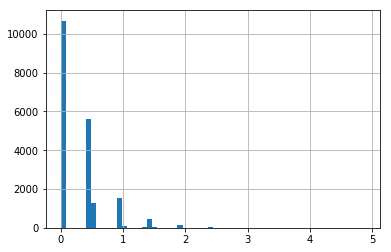

In [71]:
sessions.city_distance.hist(bins = 60)
plt.show()

we can set the threhold as 0.9 and check the ratio of random search

In [72]:
sessions['random_search'] = (sessions.city_distance >= 0.9).astype(int)
sessions.random_search.value_counts()

0    17577
1     2445
Name: random_search, dtype: int64

In [73]:
sessions.random_search.mean()

0.12211567275996404

In [74]:
random_search = sessions.loc[sessions.random_search == 1,['n_cities_search','cities']]
random_search

,n_cities_search,cities
session_id,,
5AZ2X2A9BHH5U,3,"[New York NY, Jersey City NJ, Philadelphia PA]"
7BQ7VDHTZYRPD,3,"[Vancouver BC, Victoria BC, Seattle WA]"
IGWYW7VQBR7BW,3,"[Phoenix AZ, Chandler AZ, Mesa AZ]"
EEBNPTA77L6YT,4,"[San Antonio TX, Corpus Christi TX, Arlington ..."
5HILT84J9UF4W,4,"[Calgary AB, Seattle WA, Victoria BC, Portland..."
JHLZIXZPC77JW,3,"[San Diego CA, Toronto ON, New York NY]"
ACZVRMUYETZK8,3,"[San Jose CA, Stockton CA, Sacramento CA]"
1L8PSKKA9NFMR,3,"[Phoenix AZ, Glendale AZ, Chandler AZ]"
JU7DBPB9Y4OHS,3,"[Phoenix AZ, Los Angeles CA, Chicago IL]"
